In [2]:
import QNN as qnn
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

1 Physical GPUs, 1 Logical GPUs


In [3]:
def create_cat_state(alpha, size=10):
    """Create a cat state with given alpha and Hilbert space size."""
    cat_state = qt.coherent(size, alpha) + qt.coherent(size, -alpha)
    cat_state /= cat_state.norm()  # Normalize the state
    return cat_state

def wigner_log_negativity(cat_state, xvec, yvec):
    W = qt.wigner(cat_state, xvec, yvec)
    dx = xvec[1] - xvec[0]  # Assuming uniform spacing
    dy = yvec[1] - yvec[0]

    integral = np.sum(np.abs(W)) * dx * dy
    return np.log(integral)

# Parameters for the cat state and Wigner function
alpha = range(500)  # Coherent state amplitude
size = 10  # Hilbert space size
xvec = np.linspace(-np.pi, np.pi, 100)  # X-axis values for Wigner function
yvec = np.linspace(-np.pi, np.pi, 100)  # Y-axis values for Wigner function

# Create cat state and calculate its Wigner log negativity
def wig(alpha, size, xvec, yvec):
    WLN = []
    for i in alpha:
        cat_state = create_cat_state(i, size)
        log_neg = wigner_log_negativity(cat_state, xvec, yvec)
        WLN.append(log_neg)
    
    return WLN

W = wig(alpha, size, xvec, yvec)

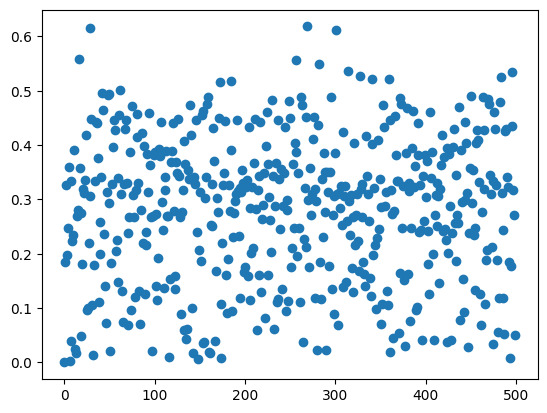

In [4]:
len(W)
plt.scatter(alpha, W)

In [5]:
X = np.linspace(-10, 10, 1000)
Y = np.log(X+20)*np.cos(X)
Y_noisy = Y + 0.1*np.random.randn(1000)
Y_noisy = (Y_noisy - np.mean(Y_noisy))/np.std(Y_noisy)
X_data = X.astype(np.complex64).reshape(-1, 1)
Y_data = Y_noisy.astype(np.complex64).reshape(-1, 1)

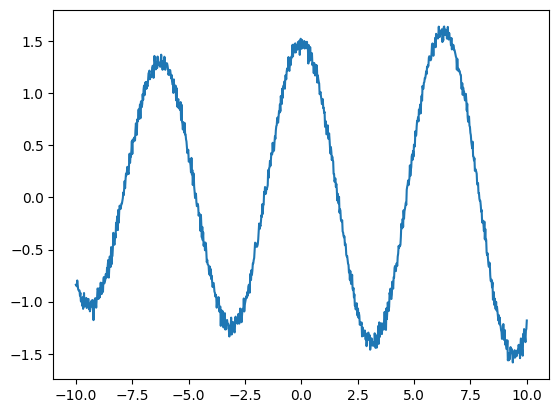

In [6]:
plt.plot(X, Y_noisy)

In [7]:
M, H = qnn.train_models(X, Y, cutoff_dim=10, configs=[(4, 100)], qmonitor = False, split = 0.3)

Epoch 100/100: 100%|██████████| 100/100 [08:59<00:00,  5.40s/it]

Total training time: 539.99 seconds
Training Complete.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 10, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 10, 1)             5         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 10, 1)             5         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 10, 1)             5         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 10, 1)             5         
                                                                 
 QuantumDecoding (QDecoder)  (None,)                   0         
                                                                 
T

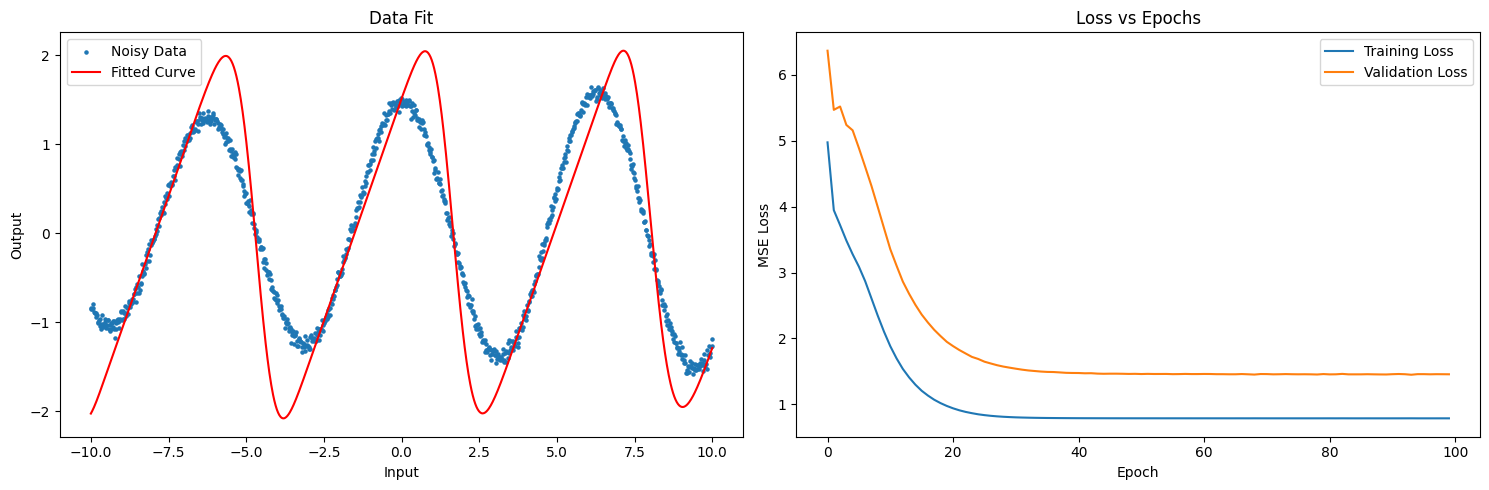

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()
Y_pred = M[0].predict(X_data, verbose = 0)
axes[0].scatter(X, Y_noisy, s=5, label='Noisy Data')
axes[0].plot(X, Y_pred, label='Fitted Curve', color='r')
#axes[0].plot(X, Y, label='True Curve', color='g')
axes[0].set_title('Data Fit')
axes[0].set_xlabel('Input')
axes[0].set_ylabel('Output')
axes[0].legend()

axes[1].plot(H[0].history['loss'], label='Training Loss')
axes[1].plot(H[0].history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss vs Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()

plt.tight_layout()
plt.show()